In [1]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2

# Builtin packages
from datetime import datetime
from importlib import reload
import logging
import os
from pathlib import Path
import sys
import warnings

# standard secondary packages
import astropy as ap
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats
import tqdm.notebook as tqdm

# development packages
import kalepy as kale
import kalepy.utils
import kalepy.plot

# --- Holodeck ----
import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC, NWTG
import holodeck.gravwaves
import holodeck.cyutils
import holodeck.evolution
import holodeck.population

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

# Load log and set logging level
log = holo.log
log.setLevel(logging.INFO)

In [9]:
DEF_NUM_FBINS = 40
DEF_PTA_DUR = 16.03     # [yrs]

# Choose observed GW-Frequency bins based on nyquist sampling
fobs_edges = utils.nyquist_freqs_edges(DEF_PTA_DUR*YR, cad=0.1*YR)
fobs_edges = fobs_edges[:DEF_NUM_FBINS+1]
fobs = utils.midpoints(fobs_edges)
fobs_cents = utils.midpoints(fobs_edges)

## Basic Example

In [3]:
gsmf = holo.sam.GSMF_Schechter()               # Galaxy Stellar-Mass Function (GSMF)
gpf = holo.sam.GPF_Power_Law()                 # Galaxy Pair Fraction         (GPF)
gmt = holo.sam.GMT_Power_Law()                 # Galaxy Merger Time           (GMT)
mmbulge = holo.relations.MMBulge_Standard()    # M-MBulge Relation            (MMB)

sam = holo.sam.Semi_Analytic_Model(
    gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge, shape=40,    
    ZERO_GMT_STALLED_SYSTEMS=True,
)

20:49:45 ERROR : Using deprecated kwarg: {key}: {val}!  In the future this will raise an error. [sam.py:__init__]


In [ ]:
hard_gw = holo.hardening.Hard_GW()
gwb = sam.gwb(
    fobs, realize=20, hard=hard_gw
)

In [ ]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', ylabel='Characteristic Strain $h_c$')

xx = (fobs[1:] + fobs[:-1]) * 0.5
ax.plot(xx, np.median(gwb, axis=1))

ax.fill_between(xx, *np.percentile(gwb, [25, 75], axis=1), alpha=0.2)

plt.show()

In [ ]:
# Fixed_Time = holo.hardening.Fixed_Time
# fixed = holo.hardening.Fixed_Time_2PL.from_sam(sam, 2 * GYR)
fixed = holo.hardening.Fixed_Time_2PL_SAM(sam, 2 * GYR)

In [ ]:
gwb_fixed = sam.new_gwb(fobs, realize=30, hard=fixed)    # calculate many different realizations

In [ ]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', ylabel='Characteristic Strain $h_c$')

xx = (fobs[1:] + fobs[:-1]) * 0.5
ax.plot(xx, np.median(gwb_fixed, axis=1))

ax.fill_between(xx, *np.percentile(gwb_fixed, [25, 75], axis=1), alpha=0.2)

plt.show()

## Compare GW-Only to Phenomenological Hardening Model

In [ ]:
NREALS = 100
sam = holo.sam.Semi_Analytic_Model(shape=30)

In [ ]:
gwb_gw = sam.new_gwb(fobs_edges, realize=100, hard=holo.hardening.Hard_GW())

In [ ]:
# hard_times = np.linspace(0.1, 12.0, 3)
hard_times = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
ntimes = len(hard_times)
nfobs = fobs.size
gwb_ph = np.zeros((ntimes, nfobs, NREALS))

for ii, htime in enumerate(hard_times):
    print(ii, htime)
    hard = holo.hardening.Fixed_Time_2PL_SAM(sam, htime*GYR)
    _gwb = sam.new_gwb(fobs_edges, realize=NREALS, hard=hard)
    gwb_ph[ii, :, :] = _gwb


In [ ]:
PLAW_FIT_NFREQS = 0
COLORBAR = False

if COLORBAR:
    kw = dict(bottom=0.25)
else:
    kw = {}
    
fig, axes = plot.figax(figsize=[10, 6], ncols=2, wspace=0.1, **kw)

xx = fobs * YR
NSAMP = 0

axes[0].set(xlabel=plot.LABEL_GW_FREQUENCY_YR, ylabel=plot.LABEL_CHARACTERISTIC_STRAIN)
axes[1].set(xlabel=plot.LABEL_GW_FREQUENCY_YR, ylabel="Ratio (phenom / GW)")

smap = plot.smap(hard_times, log=True, cmap='Spectral')
colors = smap.to_rgba(hard_times)

med_gw = np.median(gwb_gw, axis=-1)
# log10amp, gamma = utils.fit_powerlaw(xx[:PLAW_FIT_NFREQS], med_gw[:PLAW_FIT_NFREQS])
gamma = -2.0 / 3.0
if PLAW_FIT_NFREQS > 1:
    log10amp = utils.fit_powerlaw_fixed_index(xx[:PLAW_FIT_NFREQS], med_gw[:PLAW_FIT_NFREQS], index=gamma)
else:
    amp = med_gw[0] * np.power(xx[0], +2.0/3.0)
    log10amp = np.log10(amp)

plaw = np.power(10.0, log10amp + gamma * np.log10(xx))
ref = med_gw

# plot.draw_gwb(axes[0], xx, gwb_gw, color='k', nsamp=NSAMP)
axes[0].plot(xx, med_gw, color='k', zorder=10)
axes[0].plot(xx, plaw, ls=':', color='k', alpha=0.5, lw=2.0)
axes[1].plot(xx, np.ones_like(ref), ls='-', color='k', alpha=0.5)

labels = []
handles = []
for ii, htime in enumerate(hard_times):
    lab = f"{htime:.1f}"
    col = colors[ii]
    hh = plot.draw_gwb(axes[0], xx, gwb_ph[ii, :, :], color=col, nsamp=NSAMP, fracs=[0.5])
    med = np.median(gwb_ph[ii], axis=-1)
    axes[1].plot(xx, med/ref, color=col, alpha=0.5)
    handles.append(hh)
    labels.append(lab)

if COLORBAR:
    cax = fig.add_axes([0.2, 0.08, 0.6, 0.03])
    plt.colorbar(smap, label='Lifetime [Gyr]', orientation='horizontal', cax=cax)
else:
    axes[0].legend(handles, labels, fontsize=8)    

plot._twin_hz(axes[0])
plot._twin_hz(axes[1])

axes[1].yaxis.set_label_position('right')
axes[1].yaxis.set_ticks_position('right')

plt.show()
filekey = ""
fname = f"phenom-hard{filekey}.png"
fname = Path(holo._PATH_OUTPUT).joinpath(fname)
fig.savefig(fname, dpi=400)
print(f"Saved to {fname}, size {utils.get_file_size(fname)}")


In [ ]:
sepa = np.logspace(-6, 4, 30)[::-1] * PC
ntimes = len(hard_times)
numbers = []
taus = []

for ii, htime in enumerate(tqdm.tqdm_notebook(hard_times)):
    print(ii, htime, "Gyr")
    hard = holo.hardening.Fixed_Time.from_sam(sam, htime*GYR)
    edges, number, details = sam.dynamic_binary_number(hard, sepa=sepa, return_details=True)
    numbers.append(number)
    taus.append(details['tau'])
    break

In [ ]:
xx = sepa / PC
# hc2 = holo.gravwaves.char_strain_sq_from_bin_edges(edges)
mc = holo.utils.chirp_mass_mtmr(edges[0][:, np.newaxis], edges[1][np.newaxis, :])
dc = cosmo.comoving_distance(edges[2]).cgs.value

print(mc.shape)

tau = taus[0]
mc = mc[:, :, np.newaxis, np.newaxis] * np.ones_like(tau)
hc2 = np.power(mc, 4.0/3.0) / dc[np.newaxis, np.newaxis, :, np.newaxis]**2

nn = numbers[0]
nn = np.moveaxis(nn, -1, 0).reshape(xx.size, -1)
tau = np.moveaxis(tau, -1, 0).reshape(xx.size, -1)

fig, ax = plot.figax(ylim=[1e1, 1e9])
plot.draw_med_conf(ax, xx, tau/YR)
plot.draw_med_conf(ax, xx, tau/YR, weights=nn)

weights = np.moveaxis(hc2, -1, 0).reshape(xx.size, -1)
plot.draw_med_conf(ax, xx, tau/YR, weights=weights)

tw = ax.twinx()
tw.set(yscale='log')
nn = utils._integrate_grid_differential_number(edges, numbers[0], freq=False)
tw.plot(xx, np.sum(np.nan_to_num(nn), axis=(0, 1, 2)), 'k--')
# tw.plot(xx, np.sum(numbers[0], axis=(0, 1, 2)))

plt.show()

In [ ]:
xx = sepa / PC
plt.loglog(xx, number.sum(axis=(0, 1, 2)))
plt.show()

# Vary hardening-rate power-law parameters

In [ ]:
pta_dur = 16.03 * YR
nfreqs = 20
hifr = nfreqs/pta_dur
pta_cad = 1.0 / (2 * hifr)
fobs_cents = holo.utils.nyquist_freqs(pta_dur, pta_cad)
fobs_edges = holo.utils.nyquist_freqs_edges(pta_dur, pta_cad)


## Inner Power-Law

In [ ]:
space = holodeck.param_spaces.PS_Uniform_07(log, 100, 30, None)
nreals = 20

inner_list = [-1.5, -1.0, -0.5, 0.0]
sepa = np.logspace(-3, 3, 40)[::-1] * PC

sams = []
gwbs = []
dets = []

for inner in tqdm.tqdm(inner_list):
    new_pars = dict(hard_gamma_inner=inner)
    sam, hard = space.model_for_normalized_params(
        0.5, sam_shape=space.sam_shape, new_def_params=new_pars,
    )
    _gwb = sam.gwb(fobs_edges, hard=hard, realize=nreals,)
    gwbs.append(_gwb)

    edges, dnum, _details = sam.dynamic_binary_number(hard, sepa=sepa, return_details=True)
    dets.append(_details)
    # break

GWB

In [ ]:
fig, ax = plot.figax()

labels = []
handles = []
for ii, gwb in enumerate(gwbs):
    hh = plot.draw_gwb(ax, fobs_cents*YR, gwb)
    labels.append(inner_list[ii])
    handles.append(hh)
    
ax.legend(handles, labels)
plt.show()

Binary Evolution (hardening rate)

In [ ]:
import zcode.math as zmath
import zcode.plot as zplot

mup = 1e8
midx = zmath.argnearest(sam.mtot/MSOL, mup)
qup = 0.2
qidx = zmath.argnearest(sam.mrat, qup)

fig, axes = plot.figax(figsize=[10, 5], ncols=2)
xx = sepa/PC

axes[0].set(title='da/dt', xlabel='Separation [pc]', ylabel='Hardening Rate [pc/yr]')
axes[1].set(title='time', xlabel='Separation [pc]', ylabel='Hardening Time [Gyr]')

labels = []
handles = []
for ii, det in enumerate(dets):
    vals = [-det['dadt']*YR/PC, det['tau']/GYR]
    for jj, (ax, vv) in enumerate(zip(axes, vals)):
        vv = vv[midx:, qidx:, :, :].reshape(-1, sepa.size)
        hh = plot.draw_med_conf(ax, xx, vv.T, fracs=[0.5])

        if jj == 0:
            labels.append(inner_list[ii])
            handles.append(hh)

for ax, loc in zip(axes, [[10, 1e-2], [10, 1.0e-6]]):
    for pl in np.arange(1.0, 3.1, 0.5):
        l1, = ax.plot(xx, loc[1]*np.power(xx/loc[0], pl), color='0.5', ls='--', alpha=0.25)    
        l2, = ax.plot(xx, loc[1]*np.power(xx/loc[0], -pl), color='0.5', ls='--', alpha=0.25)    
        zplot.label_line(ax, l1, f"${pl:+.1f}$", x=0.4, flip_rotation=True, alpha=0.35)
        zplot.label_line(ax, l2, f"${-pl:+.1f}$", x=0.9, flip_rotation=True, alpha=0.35)
        
    ax.legend(handles, labels, loc='upper right')

plt.show()

## Outer Power-Law

In [ ]:
space = holodeck.param_spaces.PS_Uniform_07(log, 100, 30, None)
nreals = 20

outer_list = [1.0, 1.5, 2.0, 2.5]
sepa = np.logspace(-3, 3, 40)[::-1] * PC

sams = []
gwbs = []
dets = []

for outer in tqdm.tqdm(outer_list):
    new_pars = dict(hard_gamma_outer=outer)
    sam, hard = space.model_for_normalized_params(
        0.5, sam_shape=space.sam_shape, new_def_params=new_pars,
    )
    _gwb = sam.gwb(fobs_edges, hard=hard, realize=nreals,)
    gwbs.append(_gwb)

    edges, dnum, _details = sam.dynamic_binary_number(hard, sepa=sepa, return_details=True)
    dets.append(_details)

GWB

In [ ]:
fig, ax = plot.figax()

labels = []
handles = []
for ii, gwb in enumerate(gwbs):
    hh = plot.draw_gwb(ax, fobs_cents*YR, gwb)
    labels.append(inner_list[ii])
    handles.append(hh)
    
ax.legend(handles, labels)
plt.show()

Binary evolution (hardening rate)

In [ ]:
import zcode.math as zmath
import zcode.plot as zplot

mup = 1e8
midx = zmath.argnearest(sam.mtot/MSOL, mup)
qup = 0.2
qidx = zmath.argnearest(sam.mrat, qup)

fig, axes = plot.figax(figsize=[10, 5], ncols=2)
xx = sepa/PC

axes[0].set(title='da/dt', xlabel='Separation [pc]', ylabel='Hardening Rate [pc/yr]')
axes[1].set(title='time', xlabel='Separation [pc]', ylabel='Hardening Time [Gyr]')

labels = []
handles = []
for ii, det in enumerate(dets):
    vals = [-det['dadt']*YR/PC, det['tau']/GYR]
    for jj, (ax, vv) in enumerate(zip(axes, vals)):
        vv = vv[midx:, qidx:, :, :].reshape(-1, sepa.size)
        hh = plot.draw_med_conf(ax, xx, vv.T, fracs=[0.5])

        if jj == 0:
            labels.append(outer_list[ii])
            handles.append(hh)

for ax, loc in zip(axes, [[10, 1e-2], [10, 1.0e-6]]):
    for pl in np.arange(1.0, 3.1, 0.5):
        l1, = ax.plot(xx, loc[1]*np.power(xx/loc[0], pl), color='0.5', ls='--', alpha=0.25)    
        l2, = ax.plot(xx, loc[1]*np.power(xx/loc[0], -pl), color='0.5', ls='--', alpha=0.25)    
        zplot.label_line(ax, l1, f"${pl:+.1f}$", x=0.4, flip_rotation=True, alpha=0.35)
        zplot.label_line(ax, l2, f"${-pl:+.1f}$", x=0.9, flip_rotation=True, alpha=0.35)
        
    ax.legend(handles, labels, loc='upper right')

plt.show()

## Inner & Outer Power-Laws

In [ ]:
space = holodeck.param_spaces.PS_Uniform_07(log, 100, 60, None)
nreals = 100

gammas_list = [[0.0, 0.0], [-1.0, +1.0], [-1.0, +1.5], [-1.5, +1.0], [-1.5, +1.5]]
sepa = np.logspace(-3, 3, 40)[::-1] * PC

sams = []
gwbs = []
dets = []

for inner, outer in tqdm.tqdm(gammas_list):
    new_pars = dict(hard_gamma_inner=inner, hard_gamma_outer=outer)
    sam, hard = space.model_for_normalized_params(
        0.5, sam_shape=space.sam_shape, new_def_params=new_pars,
    )
    _gwb = sam.gwb(fobs_edges, hard=hard, realize=nreals,)
    gwbs.append(_gwb)

    edges, dnum, _details = sam.dynamic_binary_number(hard, sepa=sepa, return_details=True)
    dets.append(_details)

GWB

In [ ]:
fig, ax = plot.figax()

labels = []
handles = []
for ii, gwb in enumerate(gwbs):
    hh = plot.draw_gwb(ax, fobs_cents*YR, gwb, nsamp=0)
    labels.append(gammas_list[ii])
    handles.append(hh)
    
ax.legend(handles, labels)
plt.show()

Binary evolution (hardening rate)

In [ ]:
import zcode.math as zmath
import zcode.plot as zplot

mup = 1e9
midx = zmath.argnearest(sam.mtot/MSOL, mup)
qup = 0.2
qidx = zmath.argnearest(sam.mrat, qup)

fig, axes = plot.figax(figsize=[10, 5], ncols=2)
xx = sepa/PC

axes[0].set(title='da/dt', xlabel='Separation [pc]', ylabel='Hardening Rate [pc/yr]')
axes[1].set(title='time', xlabel='Separation [pc]', ylabel='Hardening Time [Gyr]')

labels = []
handles = []
for ii, det in enumerate(dets):
    vals = [-det['dadt']*YR/PC, det['tau']/GYR]
    for jj, (ax, vv) in enumerate(zip(axes, vals)):
        vv = vv[midx:, qidx:, :, :].reshape(-1, sepa.size)
        hh = plot.draw_med_conf(ax, xx, vv.T, fracs=[0.5])

        if jj == 0:
            labels.append(gammas_list[ii])
            handles.append(hh)

for ax, loc, leg in zip(axes, [[10, 1e-2], [10, 1.0e-6]], ['upper right', 'lower right']):
    for pl in np.arange(1.0, 3.1, 0.5):
        l1, = ax.plot(xx, loc[1]*np.power(xx/loc[0], pl), color='0.5', ls='--', alpha=0.25)    
        l2, = ax.plot(xx, loc[1]*np.power(xx/loc[0], -pl), color='0.5', ls='--', alpha=0.25)    
        zplot.label_line(ax, l1, f"${pl:+.1f}$", x=0.4, flip_rotation=True, alpha=0.35)
        zplot.label_line(ax, l2, f"${-pl:+.1f}$", x=0.9, flip_rotation=True, alpha=0.35)
        
    ax.legend(handles, labels, loc=leg)

plt.show()

## Power-Laws Rotation

In [19]:
SHAPE = None
NREALS = 100
space = holodeck.param_spaces.PS_Uniform_07A(log, 100, SHAPE, None)

rotation_list = [-0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75]
sepa = np.logspace(-3, 3, 40)[::-1] * PC
gamma_inner = -1.0
gamma_outer = +1.5

sams = []
gwbs = []
# dets = []

for rot in tqdm.tqdm(rotation_list):
    gi = gamma_inner+rot
    go = gamma_outer+rot
    new_pars = dict(hard_gamma_inner=gi, hard_gamma_outer=go)
    sam, hard = space.model_for_normalized_params(
        0.5, sam_shape=space.sam_shape, new_def_params=new_pars,
    )
    assert hard._gamma_inner == gi and hard._gamma_outer == go
    _gwb = sam.new_gwb(fobs_edges, hard=hard, realize=NREALS,)
    gwbs.append(_gwb)

    # edges, dnum, _details = sam.dynamic_binary_number(hard, sepa=sepa, return_details=True)
    # dets.append(_details)

GWB

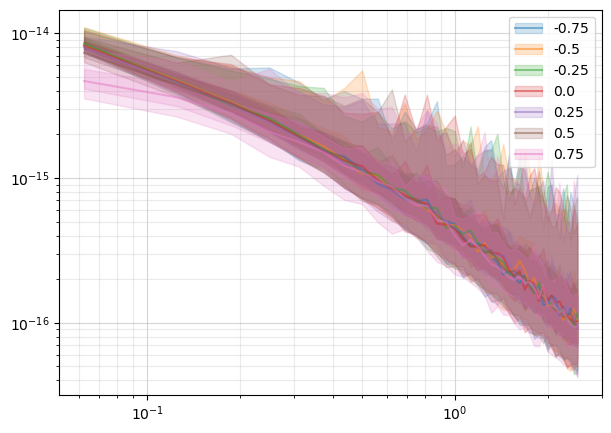

In [17]:
fig, ax = plot.figax()

labels = []
handles = []
for ii, gwb in enumerate(gwbs):
    hh = plot.draw_gwb(ax, fobs_cents*YR, gwb, nsamp=0)
    labels.append(rotation_list[ii])
    handles.append(hh)
    
ax.legend(handles, labels)
plt.show()

Binary Evolution (hardening rate)

In [ ]:
import zcode.math as zmath
import zcode.plot as zplot

mup = 1e9
midx = zmath.argnearest(sam.mtot/MSOL, mup)
qup = 0.02
qidx = zmath.argnearest(sam.mrat, qup)
print(midx, qidx)

fig, axes = plot.figax(figsize=[10, 5], ncols=2)
xx = sepa/PC

axes[0].set(title='da/dt', xlabel='Separation [pc]', ylabel='Hardening Rate [pc/yr]')
axes[1].set(title='time', xlabel='Separation [pc]', ylabel='Hardening Time [Gyr]')

labels = []
handles = []
for ii, det in enumerate(dets):
    vals = [-det['dadt']*YR/PC, det['tau']/GYR]
    for jj, (ax, vv) in enumerate(zip(axes, vals)):
        vv = vv[midx:, qidx:, :, :].reshape(-1, sepa.size)
        sel = np.all(np.isfinite(vv), axis=-1)
        hh = plot.draw_med_conf(ax, xx, vv[sel].T, fracs=[0.5])

        if jj == 0:
            labels.append(rotation_list[ii])
            handles.append(hh)

for ax, loc, leg in zip(axes, [[10, 1e-2], [10, 1.0e-6]], ['upper right', 'lower right']):
    for pl in np.arange(1.0, 3.1, 0.5):
        l1, = ax.plot(xx, loc[1]*np.power(xx/loc[0], pl), color='0.5', ls='--', alpha=0.25)    
        l2, = ax.plot(xx, loc[1]*np.power(xx/loc[0], -pl), color='0.5', ls='--', alpha=0.25)    
        zplot.label_line(ax, l1, f"${pl:+.1f}$", x=0.4, flip_rotation=True, alpha=0.35)
        zplot.label_line(ax, l2, f"${-pl:+.1f}$", x=0.9, flip_rotation=True, alpha=0.35)
        
    ax.legend(handles, labels, loc=leg)

plt.show()